# Test criterions for Benchmark

In [2]:
import sys
%load_ext autoreload
%autoreload 2
sys.path.append("./code")
from metrics import *
from criterions import plot_borda_ranks

metrics = { "ngram_based" :[BLEU,
           Sacre_BLEU,
           ROUGE_1,
           ROUGE_L,
           ROUGE_S4,
           CHRF,
           CHRF_1,
           CHRF_pp,
           METEOR],
           
           "edit_based": [WER, TER],
           
           "embedding_based" : [BARY,
            DEPTH,
            MOVER]
}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


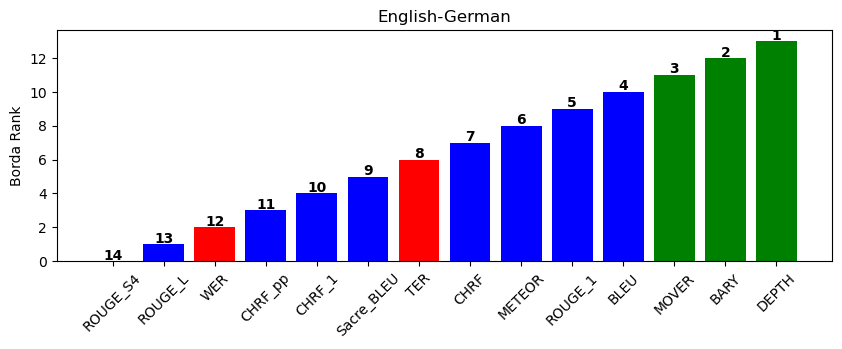

In [546]:
sl_tl = "ende"
plot_borda_ranks(
    sl_tl = sl_tl,
    metrics = metrics,
    path = "./figures/rank_metrics_" + sl_tl + ".png"
)


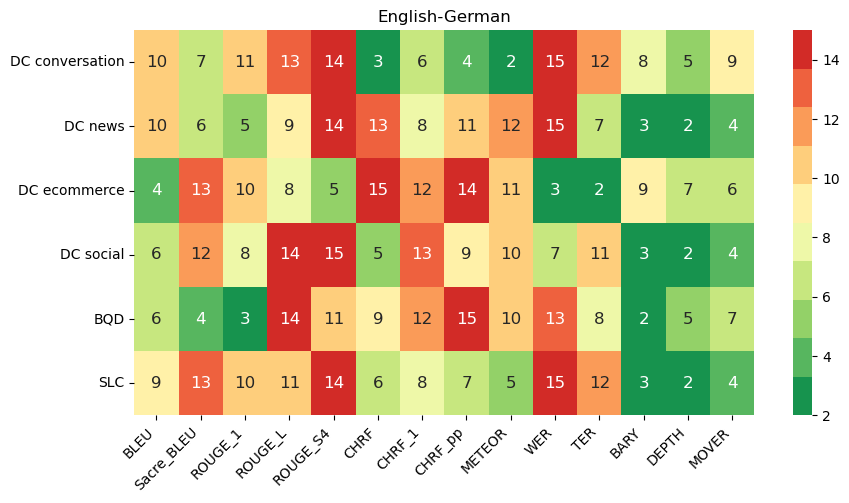

In [544]:
sl_tl = "ende"
plot_rank_per_citerion(
    sl_tl = sl_tl,
    metrics = metrics,
    path = "./figures/rank_per_criterion_"+ sl_tl + ".png"
)